<a href="https://colab.research.google.com/github/Charles980903/Proj2/blob/main/Another_copy_of_Untitled5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests

try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x, total, unit: x  # If tqdm doesn't exist, replace it with a function that does nothing
    print('**** Could not import tqdm. Please install tqdm for download progressbars! (pip install tqdm) ****')

# Python2 compatibility
try:
    input = raw_input
except NameError:
    pass

download_dict = {
    '1) Kuzushiji-MNIST (10 classes, 28x28, 70k examples)': {
        '1) MNIST data format (ubyte.gz)':
            ['http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-images-idx3-ubyte.gz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-labels-idx1-ubyte.gz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-images-idx3-ubyte.gz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-labels-idx1-ubyte.gz'],
        '2) NumPy data format (.npz)':
            ['http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-labels.npz'],
    },
    '2) Kuzushiji-49 (49 classes, 28x28, 270k examples)': {
        '1) NumPy data format (.npz)':
            ['http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-labels.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-labels.npz'],
    },
    '3) Kuzushiji-Kanji (3832 classes, 64x64, 140k examples)': {
        '1) Folders of images (.tar)':
            ['http://codh.rois.ac.jp/kmnist/dataset/kkanji/kkanji.tar'],
    }

}

# Download a list of files
def download_list(url_list):
    for url in url_list:
        path = url.split('/')[-1]
        r = requests.get(url, stream=True)
        with open(path, 'wb') as f:
            total_length = int(r.headers.get('content-length'))
            print('Downloading {} - {:.1f} MB'.format(path, (total_length / 1024000)))

            for chunk in tqdm(r.iter_content(chunk_size=1024), total=int(total_length / 1024) + 1, unit="KB"):
                if chunk:
                    f.write(chunk)
    print('All dataset files downloaded!')

# Ask the user about which path to take down the dict
def traverse_dict(d):
    print('Please select a download option:')
    keys = sorted(d.keys())  # Print download options
    for key in keys:
        print(key)

    userinput = input('> ').strip()

    try:
        selection = int(userinput) - 1
    except ValueError:
        print('Your selection was not valid')
        traverse_dict(d)  # Try again if input was not valid
        return

    selected = keys[selection]

    next_level = d[selected]
    if isinstance(next_level, list):  # If we've hit a list of downloads, download that list
        download_list(next_level)
    else:
        traverse_dict(next_level)     # Otherwise, repeat with the next level

traverse_dict(download_dict)

Please select a download option:
1) Kuzushiji-MNIST (10 classes, 28x28, 70k examples)
2) Kuzushiji-49 (49 classes, 28x28, 270k examples)
3) Kuzushiji-Kanji (3832 classes, 64x64, 140k examples)
> 1
Please select a download option:
1) MNIST data format (ubyte.gz)
2) NumPy data format (.npz)
> 
Your selection was not valid
Please select a download option:
1) MNIST data format (ubyte.gz)
2) NumPy data format (.npz)
> 2


100%|██████████| 17954/17954 [00:10<00:00, 1763.22KB/s]


100%|██████████| 30/30 [00:00<00:00, 398.99KB/s]


100%|██████████| 3008/3008 [00:01<00:00, 1582.39KB/s]


100%|██████████| 6/6 [00:00<00:00, 18490.69KB/s]

All dataset files downloaded!


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,ConfusionMatrixDisplay
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import os
import random
from tensorflow.keras.optimizers import Adam
import pandas as pd
import time

def set_seed(seed=42):
    """Ensure reproducibility by setting random seeds."""
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.config.experimental.enable_op_determinism()
set_seed(42)


def log_time(step_name, start_time):
    end_time = time.time()
    print(f"{step_name} completed in {end_time - start_time:.2f} seconds.")
    return end_time

In [ ]:

train_images = np.load('kmnist-train-imgs.npz')['arr_0']
train_labels = np.load('kmnist-train-labels.npz')['arr_0']
test_images = np.load('kmnist-test-imgs.npz')['arr_0']
test_labels = np.load('kmnist-test-labels.npz')['arr_0']

train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Flatten the images for input into the Stacked Autoencoder
train_images_flattened = train_images.reshape(-1, 784)
test_images_flattened = test_images.reshape(-1, 784)

x_test = test_images_flattened
y_test = test_labels


x_train, x_val, y_train, y_val = train_images_flattened, test_images_flattened, train_labels, test_labels


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import time
import matplotlib.pyplot as plt


svm_classifier_original = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)


start_time = time.time()
svm_classifier_original.fit(x_train, y_train)
end_time = time.time()


test_predictions_original = svm_classifier_original.predict(x_test)


test_accuracy_original = accuracy_score(y_test, test_predictions_original)


conf_matrix_original = confusion_matrix(y_test, test_predictions_original)





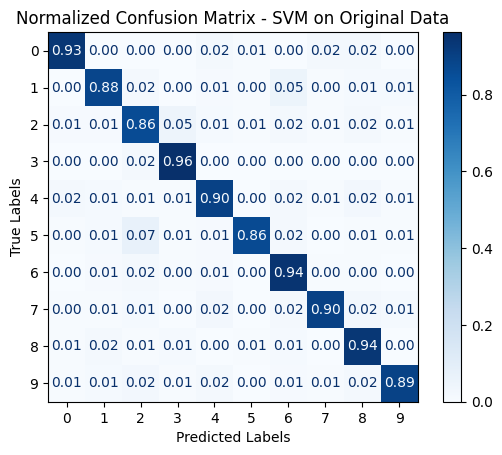

Test Accuracy on Original Data: 0.9071


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


normalized_conf_matrix_original = confusion_matrix(y_test, test_predictions_original, normalize='true')


disp = ConfusionMatrixDisplay(confusion_matrix=normalized_conf_matrix_original, display_labels=np.arange(10))
disp.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.title("Normalized Confusion Matrix - SVM on Original Data")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

print(f"Test Accuracy on Original Data: {test_accuracy_original:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6707 - loss: 0.9972 - val_accuracy: 0.7867 - val_loss: 0.6748
Epoch 2/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9122 - loss: 0.2862 - val_accuracy: 0.8475 - val_loss: 0.5094
Epoch 3/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9440 - loss: 0.1836 - val_accuracy: 0.8723 - val_loss: 0.4485
Epoch 4/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9618 - loss: 0.1256 - val_accuracy: 0.8844 - val_loss: 0.4316
Epoch 5/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9743 - loss: 0.0879 - val_accuracy: 0.8833 - val_loss: 0.4773
Epoch 6/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9819 - loss: 0.0628 - val_accuracy: 0.8979 - val_loss: 0.4464
Epoch 7/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9864 - loss: 0.0469 - val_accuracy: 0.9028 - val_loss: 0.4443
Epoch 8/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9912 - loss: 0.0313 - val_accu

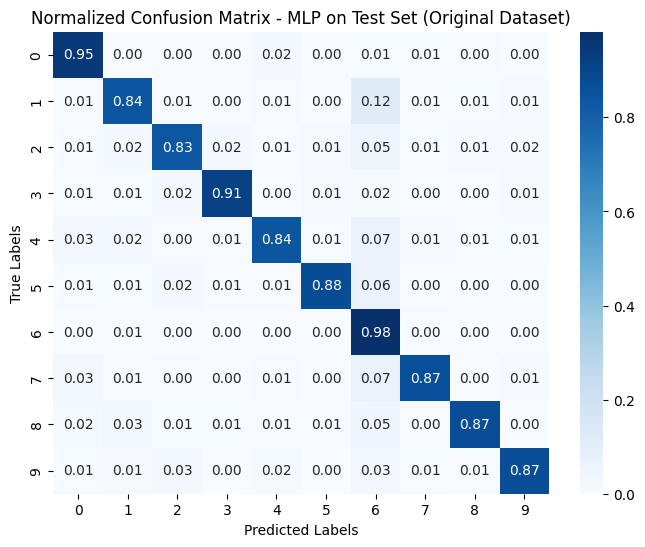

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np

# One-hot encode the labels for the original dataset
y_train_one_hot = tf.one_hot(train_labels, depth=10)
y_val_one_hot = tf.one_hot(y_val, depth=10)
y_test_one_hot = tf.one_hot(test_labels, depth=10)


num_layers = 3
num_units = 512
learning_rate = 0.001
patience = 7


model_original = Sequential([Flatten(input_shape=(28 * 28,))])
for _ in range(num_layers):
    model_original.add(Dense(num_units, activation='sigmoid'))
model_original.add(Dense(10, activation='softmax'))


model_original.compile(optimizer=Adam(learning_rate=learning_rate),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])


early_stopping_original = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)


start_time_original = time.time()
history_original = model_original.fit(train_images_flattened, y_train_one_hot,
                                      epochs=100,
                                      validation_data=(x_val, y_val_one_hot),
                                      batch_size=64,
                                      callbacks=[early_stopping_original],
                                      verbose=1)
training_time_original = time.time() - start_time_original
print(f"MLP Training Time (Original Dataset): {training_time_original:.2f} seconds")


y_pred_original = model_original.predict(x_test)
y_pred_classes_original = np.argmax(y_pred_original, axis=1)
y_true_original = test_labels


test_accuracy_original = accuracy_score(y_true_original, y_pred_classes_original)
print(f"Test Accuracy (Original Dataset): {test_accuracy_original:.4f}")

cm_original_mlp = confusion_matrix(y_true_original, y_pred_classes_original, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm_original_mlp, annot=True, cmap='Blues', fmt='.2f')
plt.title("Normalized Confusion Matrix - MLP on Test Set (Original Dataset)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
def build_sae(bottleneck_size):
    # Encoder
    input_layer = Input(shape=(784,), name="input_layer")
    encoder = Dense(800, activation='relu', name="encoder_1")(input_layer)
    encoder = Dense(200, activation='relu', name="encoder_2")(encoder)
    bottleneck = Dense(bottleneck_size, activation='relu', name="bottleneck")(encoder)

    # Decoder
    decoder = Dense(200, activation='relu', name="decoder_1")(bottleneck)
    decoder = Dense(800, activation='relu', name="decoder_2")(decoder)
    output_layer = Dense(784, activation='sigmoid', name="output_layer")(decoder)

    # Build model
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    return autoencoder

In [ ]:

def extract_features(autoencoder, data):

    encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.layers[3].output)
    features = encoder_model.predict(data)
    return features

In [ ]:
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
from itertools import product


bottleneck_sizes = [32, 64, 128]
batch_sizes = [64, 128,256]
patience_values = [5, 10]

n_folds = 3
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

cv_results = []


for bottleneck_size, batch_size, patience in product(bottleneck_sizes, batch_sizes, patience_values):
    print(f"Testing: Bottleneck size={bottleneck_size}, Batch size={batch_size}, Patience={patience}")

    fold_accuracies = []


    for train_idx, val_idx in kf.split(x_train):

        x_train_fold, x_val_fold = x_train[train_idx], x_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        autoencoder = build_sae(bottleneck_size)
        autoencoder.compile(optimizer='adam', loss='mse')


        early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)


        autoencoder.fit(
            x_train_fold, x_train_fold,
            epochs=50,
            batch_size=batch_size,
            validation_data=(x_val_fold, x_val_fold),
            callbacks=[early_stopping],
            verbose=0
        )


        train_features = extract_features(autoencoder, x_train_fold)
        val_features = extract_features(autoencoder, x_val_fold)


        scaler = StandardScaler()
        train_features_scaled = scaler.fit_transform(train_features)
        val_features_scaled = scaler.transform(val_features)


        svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)


        svm_classifier.fit(train_features_scaled, y_train_fold)
        val_predictions = svm_classifier.predict(val_features_scaled)


        val_accuracy = accuracy_score(y_val_fold, val_predictions)

        fold_accuracies.append(val_accuracy)


    avg_val_accuracy = np.mean(fold_accuracies)
    print(f"Avg Validation Accuracy: {avg_val_accuracy:.4f}")
    cv_results.append({
        'bottleneck_size': bottleneck_size,
        'batch_size': batch_size,
        'patience': patience,
        'avg_val_accuracy': avg_val_accuracy
    })


results_df = pd.DataFrame(cv_results)


best_row = results_df.loc[results_df['avg_val_accuracy'].idxmax()]
print("\nBest Hyperparameters:")
print(best_row)


Testing: Bottleneck size=32, Batch size=64, Patience=5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Avg Validation Accuracy: 0.9586
Testing: Bottleneck size=32, Batch size=64, Patience=10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Avg Validation Accuracy: 0.9587
Testing: Bottleneck size=32, Batch size=128, Patience=5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Avg Validatio

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import numpy as np


bottleneck_sizes = [56, 60, 64, 68, 72,76]

results = []  #
confusion_matrices = {}

kf = KFold(n_splits=3, shuffle=True, random_state=42)

for bottleneck_size in bottleneck_sizes:
    print(f"\nTesting: Bottleneck size = {bottleneck_size}")

    fold_accuracies = []
    fold_losses = []


    for train_idx, val_idx in kf.split(x_train):

        x_train_fold, x_val_fold = x_train[train_idx], x_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]


        autoencoder = build_sae(bottleneck_size)
        autoencoder.compile(optimizer='adam', loss='mse')


        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


        autoencoder.fit(
            x_train_fold, x_train_fold,
            epochs=50,
            batch_size=64,
            validation_data=(x_val_fold, x_val_fold),
            callbacks=[early_stopping],
            verbose=0
        )

        # Extract bottleneck features for SVM
        train_features = extract_features(autoencoder, x_train_fold)
        val_features = extract_features(autoencoder, x_val_fold)

        scaler = StandardScaler()
        train_features_scaled = scaler.fit_transform(train_features)
        val_features_scaled = scaler.transform(val_features)

        # Train SVM
        svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
        svm_classifier.fit(train_features_scaled, y_train_fold)

        val_predictions = svm_classifier.predict(val_features_scaled)
        val_accuracy = accuracy_score(y_val_fold, val_predictions)

        fold_accuracies.append(val_accuracy)


    avg_val_acc = np.mean(fold_accuracies)


    results.append({
        'bottleneck_size': bottleneck_size,
        'avg_val_acc': avg_val_acc
    })


    print(f"Bottleneck size = {bottleneck_size}, Avg Validation Accuracy = {avg_val_acc:.4f}")


results_df = pd.DataFrame(results)


best_row = results_df.loc[results_df['avg_val_acc'].idxmax()]
best_bottleneck_size = best_row['bottleneck_size']
best_val_acc = best_row['avg_val_acc']

print(f"\nBest Bottleneck Size: {best_bottleneck_size}")
print(f"Best Avg Validation Accuracy: {best_val_acc:.4f}")





Testing: Bottleneck size = 56
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Bottleneck size = 56, Avg Validation Accuracy = 0.9641

Testing: Bottleneck size = 60
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Bottleneck size = 60, Avg Validation Accuracy = 0.9630

Testing: Bottleneck size = 64
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Bottleneck size = 64, Avg Validation Accu

Epoch 1/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0728 - val_loss: 0.0340
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0279 - val_loss: 0.0272
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0225 - val_loss: 0.0246
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0201 - val_loss: 0.0232
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0188 - val_loss: 0.0228
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0178 - val_loss: 0.0218
Epoch 7/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0170 - val_loss: 0.0210
Epoch 8/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0162 - val_loss: 0.0209
Epoch 9/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0160 - val_loss: 0.0208
Epoch 10/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0162 - val_loss: 0.0208
Epoch 11/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0160 - val_loss: 0.0209
Epoch 12/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

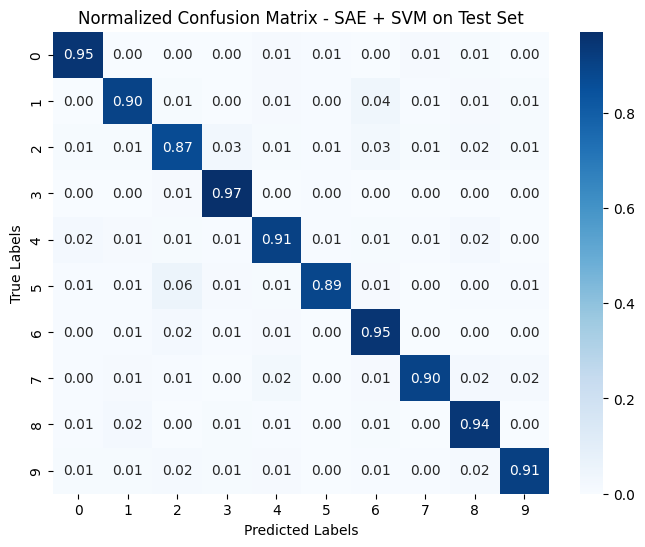

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title):
    """Plot a normalized confusion matrix."""
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f')
    plt.title(title)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()



autoencoder = build_sae(64)
autoencoder.compile(optimizer='adam', loss='mse')


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start_time = time.time()

autoencoder.fit(
    x_train, x_train,
    epochs=50,
    batch_size=64,
    validation_data=(x_val, x_val),
    callbacks=[early_stopping],
    verbose=1
)


train_features = extract_features(autoencoder, x_train)



scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_classifier.fit(train_features_scaled, y_train)
end_time = time.time()



test_features = extract_features(autoencoder, x_test)
test_features_scaled = scaler.transform(test_features)




print(f"SAE +SVM Training Time: {end_time - start_time:.2f} seconds")

test_predictions = svm_classifier.predict(test_features_scaled)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"\nSAE + SVM Test Accuracy: {test_accuracy:.4f}")

cm = confusion_matrix(y_test, test_predictions, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f')
plt.title("Normalized Confusion Matrix - SAE + SVM on Test Set")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
sae_total_params = autoencoder.count_params()
print(f"Total parameters in SAE model: {sae_total_params}")

Total parameters in SAE model: 1602848


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


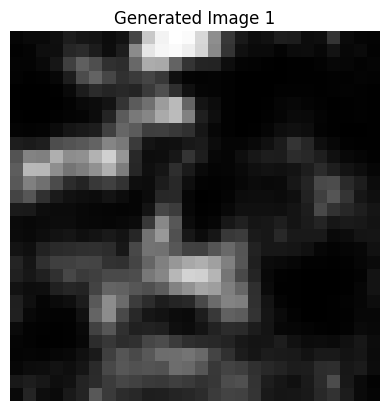

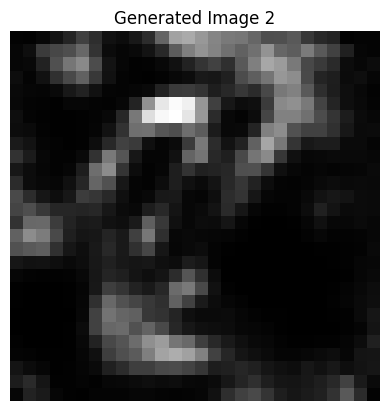

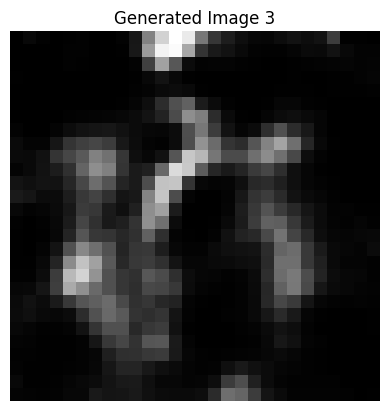

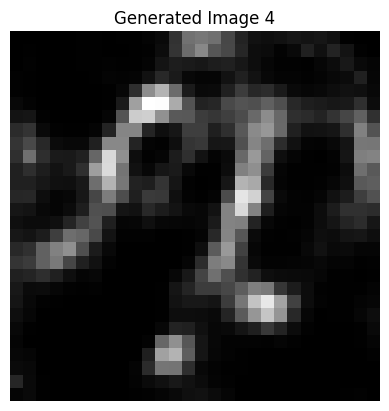

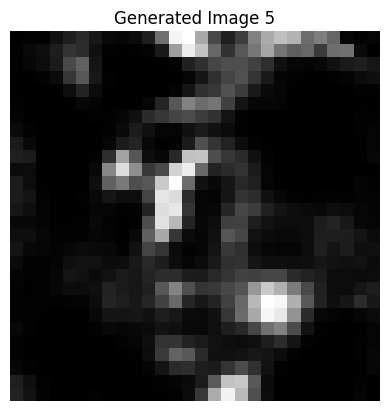

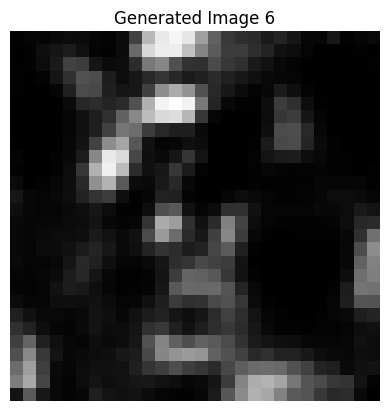

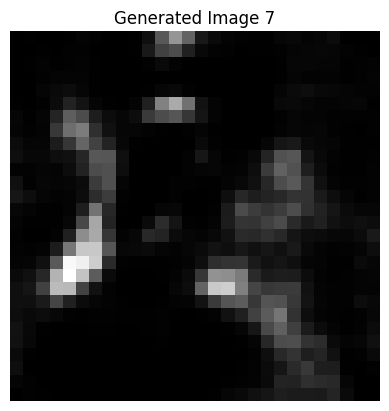

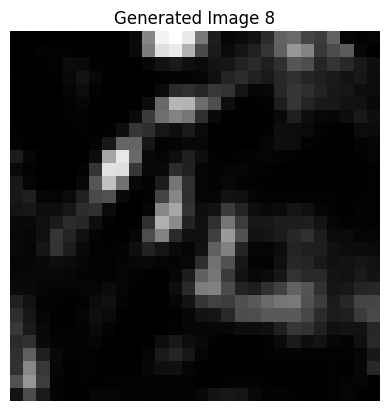

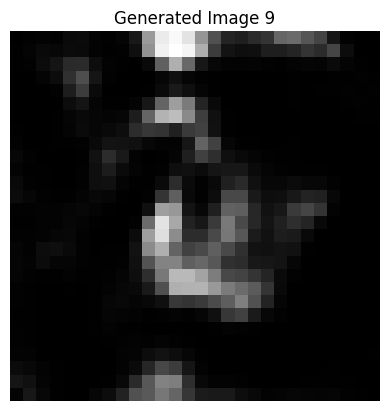

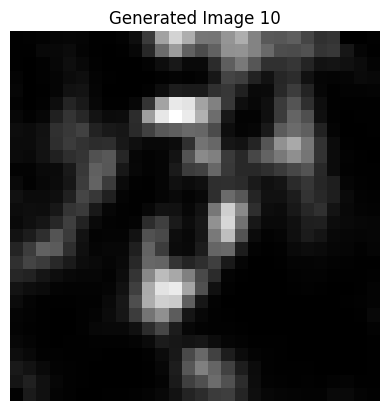

In [ ]:

def extract_decoder(autoencoder):


    bottleneck_dim = autoencoder.get_layer('bottleneck').units
    decoder_input = Input(shape=(bottleneck_dim,), name="decoder_input")


    decoder_output = autoencoder.get_layer('decoder_1')(decoder_input)
    decoder_output = autoencoder.get_layer('decoder_2')(decoder_output)
    decoder_output = autoencoder.get_layer('output_layer')(decoder_output)


    decoder = Model(inputs=decoder_input, outputs=decoder_output, name="decoder")
    return decoder

decoder = extract_decoder(autoencoder)


num_images = 10
bottleneck_size = autoencoder.get_layer('bottleneck').units
bottleneck_codes = np.random.normal(0, 1, size=(num_images, bottleneck_size))  # Random latent codes

# Use the decoder to generate images
generated_images = decoder.predict(bottleneck_codes)

# Visualize the generated images
for i in range(num_images):
    plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')  # Reshape to 28x28 if input size is 784
    plt.title(f"Generated Image {i+1}")
    plt.axis('off')
    plt.show()

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt

# Extract representative codes for each class
def extract_representative_codes(autoencoder, x_train, y_train):
    """
    Extract one representative bottleneck code for each class.
    """
    bottleneck_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('bottleneck').output)
    representative_codes = []
    for class_label in np.unique(y_train):
        class_indices = np.where(y_train == class_label)[0]
        # Take the first sample from each class
        representative_code = bottleneck_model.predict(x_train[class_indices[:1]], verbose=0)[0]
        representative_codes.append(representative_code)
    return np.array(representative_codes)


#  Add Gaussian noise to bottleneck codes
def generate_noisy_images(decoder, representative_codes, num_images=1000, noise_variances=[1, 2, 4]):
    """
    Generate images by adding Gaussian noise to the bottleneck codes.
    """
    num_classes = len(representative_codes)
    images_per_class = num_images // num_classes
    augmented_images = []
    augmented_labels = []

    for variance in noise_variances:
        for class_idx, code in enumerate(representative_codes):
            for _ in range(images_per_class // len(noise_variances)):
                noisy_code = code + np.random.normal(0, variance, size=code.shape)
                generated_image = decoder.predict(np.expand_dims(noisy_code, axis=0), verbose=0)[0]
                augmented_images.append(generated_image)
                augmented_labels.append(class_idx)

    return np.array(augmented_images), np.array(augmented_labels)

# Generate and visualize images
# Extract the trained decoder
decoder = extract_decoder(autoencoder)

# Extract representative codes for each class
representative_codes = extract_representative_codes(autoencoder, x_train, y_train)

# Generate 1,000 noisy images
noise_variances = [1, 2, 4]
augmented_images, augmented_labels = generate_noisy_images(decoder, representative_codes, num_images=1000, noise_variances=noise_variances)



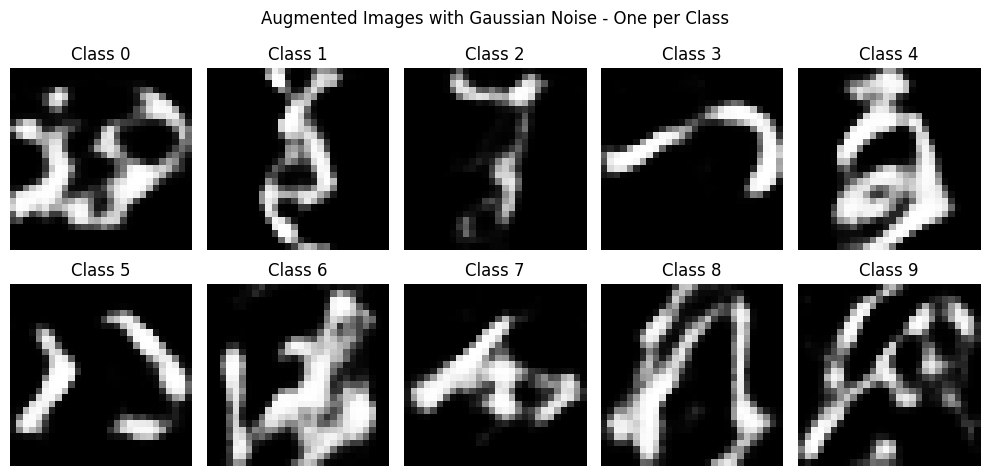

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


unique_labels = np.unique(augmented_labels)

plt.figure(figsize=(10, 5))
for i, label in enumerate(unique_labels):
    # Find the first image corresponding to each label
    index = np.where(augmented_labels == label)[0][0]
    plt.subplot(2, 5, i + 1)
    plt.imshow(augmented_images[index].reshape(28, 28), cmap='gray')
    plt.title(f"Class {label}")
    plt.axis('off')

plt.suptitle("Augmented Images with Gaussian Noise - One per Class")
plt.tight_layout()
plt.show()

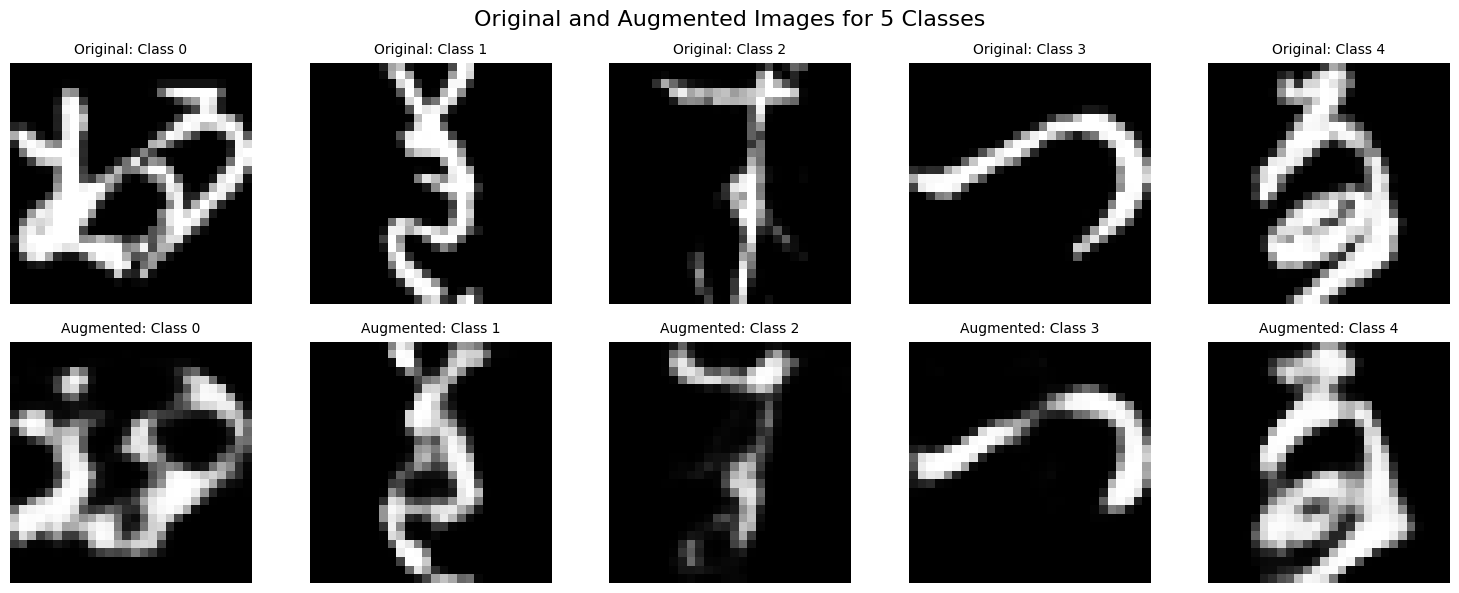

In [ ]:
plt.figure(figsize=(15, 6))

# Loop through the first 5 unique class labels
for i, label in enumerate(np.unique(augmented_labels)[:5]):
    # Find an original image corresponding to the label
    original_index = np.where(y_train == label)[0][0]
    original_image = x_train[original_index].reshape(28, 28)

    # Find an augmented image corresponding to the label
    augmented_index = np.where(augmented_labels == label)[0][0]
    augmented_image = augmented_images[augmented_index].reshape(28, 28)

    # Plot the original image
    plt.subplot(2, 5, i + 1)
    plt.imshow(original_image, cmap='gray', interpolation='nearest')
    plt.title(f"Original: Class {label}", fontsize=10)
    plt.axis('off')

    # Plot the augmented image
    plt.subplot(2, 5, i + 6)
    plt.imshow(augmented_image, cmap='gray', interpolation='nearest')
    plt.title(f"Augmented: Class {label}", fontsize=10)
    plt.axis('off')

plt.suptitle("Original and Augmented Images for 5 Classes", fontsize=16)
plt.tight_layout(h_pad=2, w_pad=2)
plt.show()



Epoch 1/50
954/954 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0692 - val_loss: 0.0357
Epoch 2/50
954/954 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0270 - val_loss: 0.0281
Epoch 3/50
954/954 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0223 - val_loss: 0.0267
Epoch 4/50
954/954 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0201 - val_loss: 0.0262
Epoch 5/50
954/954 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0188 - val_loss: 0.0240
Epoch 6/50
954/954 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0180 - val_loss: 0.0231
Epoch 7/50
954/954 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0175 - val_loss: 0.0230
Epoch 8/50
954/954 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0171 - val_loss: 0.0231
Epoch 9/50
954/954 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0167 - val_loss: 0.0217
Epoch 10/50
954/954 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0160 - val_loss: 0.0218
Epoch 11/50
954/954 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0156 - val_loss: 0.0213
Epoch 12/50
954/954 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

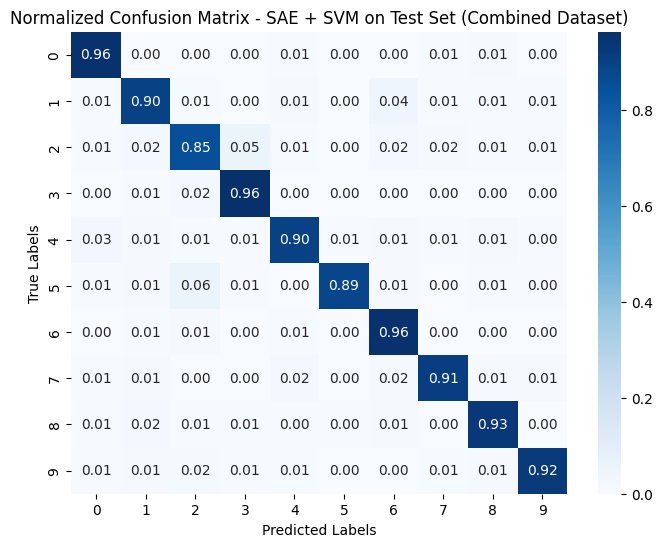

In [ ]:

combined_train_images = np.vstack([x_train, augmented_images])  # Combine original and generated images
combined_train_labels = np.hstack([y_train, augmented_labels])  # Combine corresponding labels


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the autoencoder on the combined training dataset

autoencoder_augmented = build_sae(64)
autoencoder_augmented.compile(optimizer='adam', loss='mse')


start_time = time.time()
autoencoder_augmented.fit(
    combined_train_images, combined_train_images,  # Train on combined dataset
    epochs=50,
    batch_size=64,
    validation_data=(x_val, x_val),
    callbacks=[early_stopping],
    verbose=1
)

train_features_combined = extract_features(autoencoder_augmented, combined_train_images)
# Step 3: Scale the Features
scaler = StandardScaler()
train_features_scaled_combined = scaler.fit_transform(train_features_combined)
svm_classifier_combined = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_classifier_combined.fit(train_features_scaled_combined, combined_train_labels)
end_time = time.time()
training_time = end_time - start_time
print(f"Training Time (Combined Dataset): {training_time:.2f} seconds")

# Extract Bottleneck Features



training_time = time.time() - start_time
test_features_combined = extract_features(autoencoder_augmented, x_test)


test_features_scaled_combined = scaler.transform(test_features_combined)

test_predictions_combined = svm_classifier_combined.predict(test_features_scaled_combined)
test_accuracy_combined = accuracy_score(y_test, test_predictions_combined)

print(f"\nSAE + SVM Test Accuracy (Combined Dataset): {test_accuracy_combined:.4f}")


cm_combined = confusion_matrix(y_test, test_predictions_combined, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm_combined, annot=True, cmap='Blues', fmt='.2f')
plt.title("Normalized Confusion Matrix - SAE + SVM on Test Set (Combined Dataset)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
953/953 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6703 - loss: 0.9828 - val_accuracy: 0.7815 - val_loss: 0.7036
Epoch 2/100
953/953 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9110 - loss: 0.2853 - val_accuracy: 0.8414 - val_loss: 0.5275
Epoch 3/100
953/953 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9447 - loss: 0.1804 - val_accuracy: 0.8692 - val_loss: 0.4562
Epoch 4/100
953/953 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9635 - loss: 0.1224 - val_accuracy: 0.8811 - val_loss: 0.4464
Epoch 5/100
953/953 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9752 - loss: 0.0834 - val_accuracy: 0.8799 - val_loss: 0.4875
Epoch 6/100
953/953 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9828 - loss: 0.0576 - val_accuracy: 0.8790 - val_loss: 0.5295
Epoch 7/100
953/953 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9857 - loss: 0.0447 - val_accuracy: 0.8691 - val_loss: 0.6109
Epoch 8/100
953/953 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9875 - loss: 0.0380 - val_accu

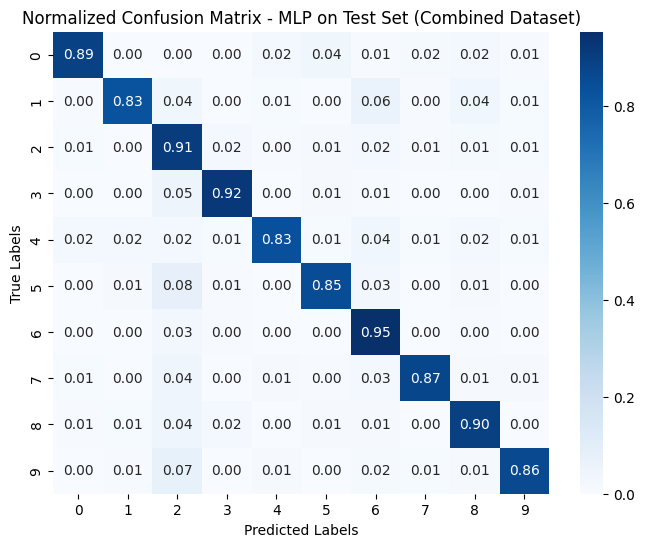

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt




x_test_processed = test_images.reshape(test_images.shape[0], -1) / 255.0  # Process test data similarly

# One-hot encode the labels
y_train_augmented_one_hot = tf.one_hot(combined_train_labels, depth=10)
test_labels_one_hot = tf.one_hot(test_labels, depth=10)
val_labels_one_hot = tf.one_hot(y_val, depth=10)


num_layers = 3
num_units = 512
learning_rate = 0.001
patience = 7

time_augmented_MLP = time.time()

model = Sequential([Flatten(input_shape=(28 * 28,))])
for _ in range(num_layers):
    model.add(Dense(num_units, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)


start_time = time.time()

history = model.fit(combined_train_images, y_train_augmented_one_hot, epochs=100,
                    validation_data=(x_val, val_labels_one_hot),
                    batch_size=64, callbacks=[early_stopping], verbose=1)
training_time = time.time() - start_time
print(f"MLP Training Time (Combined Dataset): {training_time:.2f} seconds")



y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_labels


test_accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Test Accuracy: {test_accuracy:.4f}")


cm_combined_mlp = confusion_matrix(y_true, y_pred_classes, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm_combined_mlp, annot=True, cmap='Blues', fmt='.2f')
plt.title("Normalized Confusion Matrix - MLP on Test Set (Combined Dataset)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


Training SAE with bottleneck size 16
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


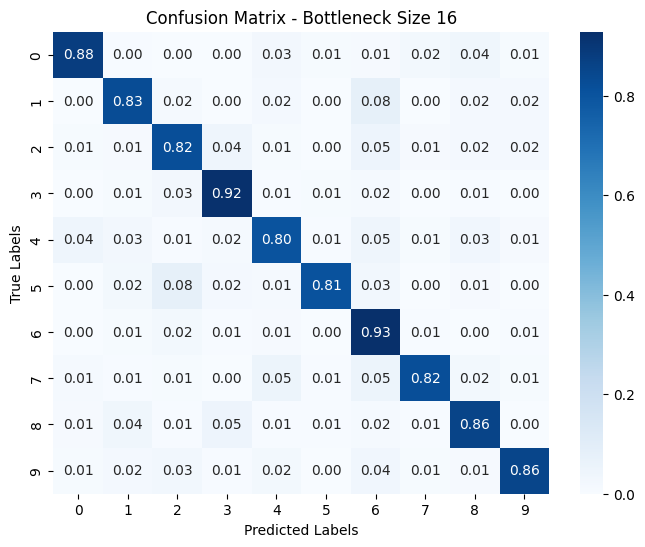

Bottleneck size 16 - Test Accuracy: 0.8529
Training SAE with bottleneck size 32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


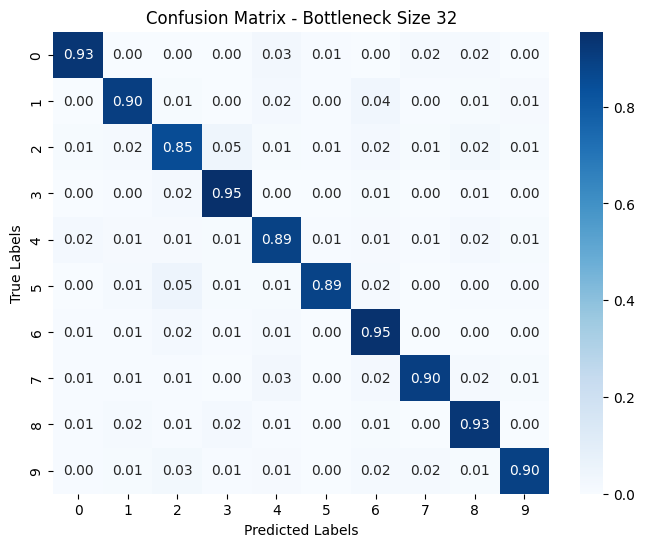

Bottleneck size 32 - Test Accuracy: 0.9080
Training SAE with bottleneck size 64
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


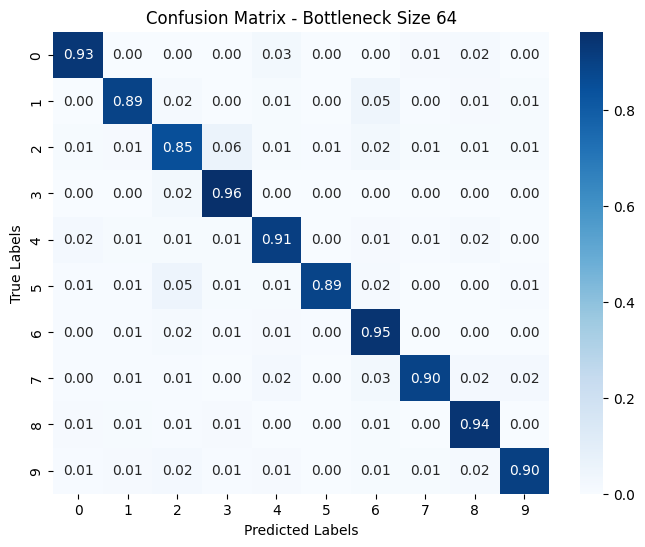

Bottleneck size 64 - Test Accuracy: 0.9131
Training SAE with bottleneck size 128
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


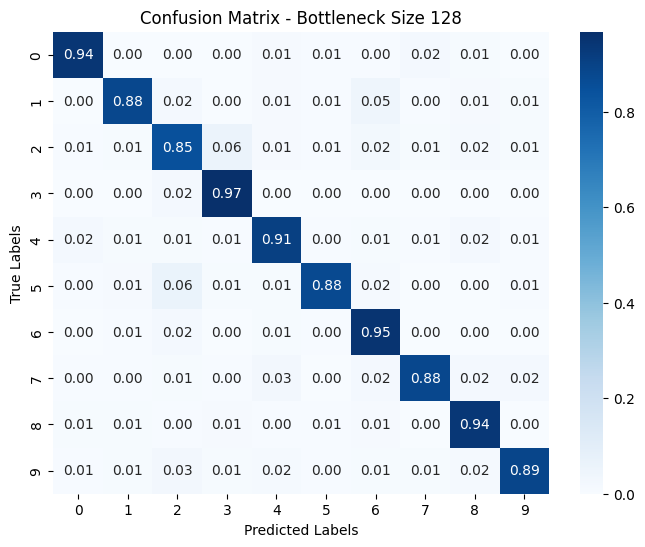

Bottleneck size 128 - Test Accuracy: 0.9096
Training SAE with bottleneck size 256
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


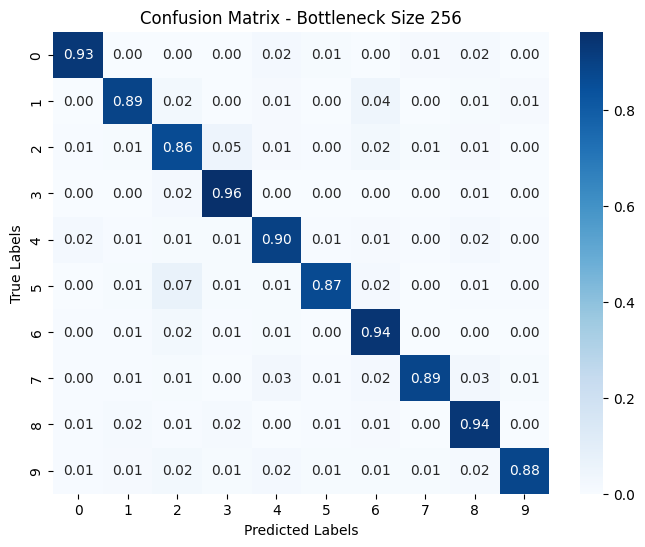

Bottleneck size 256 - Test Accuracy: 0.9059
Training SAE with bottleneck size 400
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


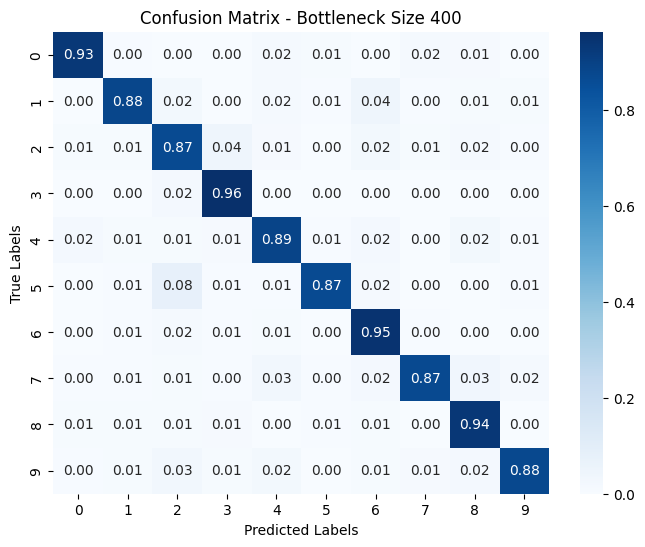

Bottleneck size 400 - Test Accuracy: 0.9037


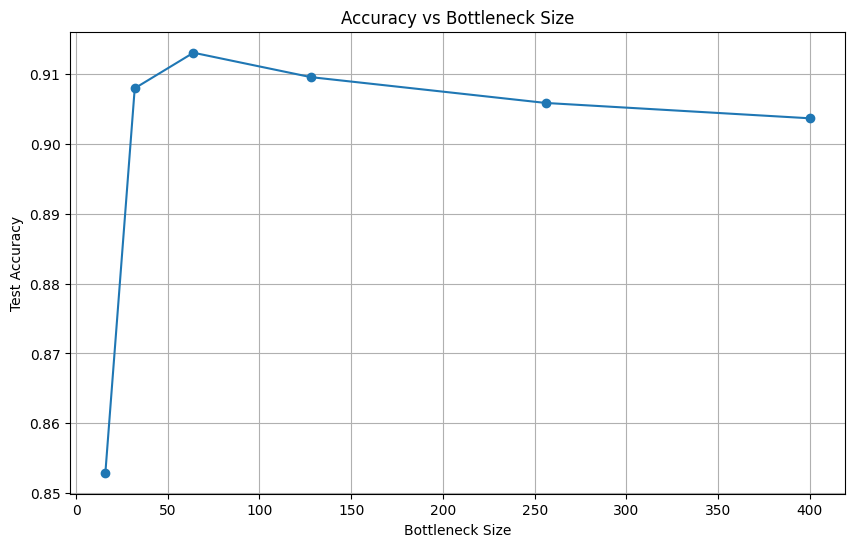

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import numpy as np


def plot_confusion_matrix(y_true, y_pred, title):
    """Plot a normalized confusion matrix."""
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f')
    plt.title(title)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

bottleneck_sizes = [16, 32, 64, 128, 256, 400]
accuracies = []

for size in bottleneck_sizes:
    print(f"Training SAE with bottleneck size {size}")

    autoencoder = build_sae(size)
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(x_train, x_train, epochs=50, batch_size=64, validation_data=(x_val, x_val), verbose=0)

    train_features = extract_features(autoencoder, x_train)
    test_features = extract_features(autoencoder, x_test)


    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_features)
    test_features_scaled = scaler.transform(test_features)


    svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale')
    svm_classifier.fit(train_features_scaled, y_train)

    test_predictions = svm_classifier.predict(test_features_scaled)
    accuracy = accuracy_score(y_test, test_predictions)
    accuracies.append(accuracy)


    plot_confusion_matrix(y_test, test_predictions, f"Confusion Matrix - Bottleneck Size {size}")
    print(f"Bottleneck size {size} - Test Accuracy: {accuracy:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(bottleneck_sizes, accuracies, marker='o')
plt.title("Accuracy vs Bottleneck Size")
plt.xlabel("Bottleneck Size")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.show()


## Part 2

In [ ]:
from re import X

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


x_train = train_images.reshape(-1, 784)
x_test = test_images.reshape(-1, 784)


x_train, x_val, y_train, y_val = x_train, x_test,y_train,test_labels


y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
y_test = to_categorical(test_labels, num_classes=10)


In [ ]:
num_classes = 10
bottleneck_dim = 10

np.random.seed(42)
targets = np.random.randn(num_classes, bottleneck_dim)
targets = targets / np.linalg.norm(targets, axis=1, keepdims=True)
targets_tensor = tf.convert_to_tensor(targets, dtype=tf.float32)


In [ ]:
from sklearn.preprocessing import normalize
from tensorflow.keras.layers import Input, Dense, Layer


def generate_orthogonal_vectors(num_classes, bottleneck_dim):
    """
    Generate orthogonal vectors for the penalty layer targets.
    """
    random_matrix = np.random.randn(num_classes, bottleneck_dim)
    orthogonal_matrix, _ = np.linalg.qr(random_matrix)
    orthogonal_matrix = normalize(orthogonal_matrix, axis=1)
    return orthogonal_matrix

class PenaltyLayer(Layer):
    def __init__(self, targets, lambda_penalty, distance_metric='euclidean', p=3, **kwargs):
        super(PenaltyLayer, self).__init__(**kwargs)
        self.targets = targets
        self.lambda_penalty = lambda_penalty
        self.distance_metric = distance_metric
        self.p = p  # Minkowski parameter

    def call(self, bottleneck_outputs, labels):
        targets_batch = tf.gather(self.targets, tf.argmax(labels, axis=1))

        if self.distance_metric == 'manhattan':
            distances = tf.reduce_sum(tf.abs(bottleneck_outputs - targets_batch), axis=1)
        elif self.distance_metric == 'minkowski':
            distances = tf.reduce_sum(tf.pow(tf.abs(bottleneck_outputs - targets_batch), self.p), axis=1)
            distances = tf.pow(distances, 1.0 / self.p)
        else:  # Euclidean
            squared_diff = tf.square(bottleneck_outputs - targets_batch)
            distances = tf.sqrt(tf.reduce_sum(squared_diff, axis=1))

        penalty_R = tf.reduce_mean(distances)
        self.add_loss(self.lambda_penalty * penalty_R)
        return bottleneck_outputs


def create_custom_loss(model):
    def custom_loss(y_true, y_pred):
        reconstruction_loss = tf.reduce_mean(tf.keras.losses.mse(y_true, y_pred))
        penalty_term = sum(model.losses)
        total_loss = reconstruction_loss + penalty_term
        return total_loss
    return custom_loss

def extract_bottleneck_features(autoencoder, x_data):
    bottleneck_model = Model(inputs=autoencoder.input[0], outputs=autoencoder.get_layer('bottleneck').output)
    return bottleneck_model.predict(x_data)

def train_svm(features_train, labels_train, features_test, labels_test):
    svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)
    svm_classifier.fit(features_train, labels_train)
    train_accuracy = svm_classifier.score(features_train, labels_train)
    test_accuracy = svm_classifier.score(features_test, labels_test)
    return train_accuracy, test_accuracy

In [ ]:
# Generate the target sets
direct_targets = tf.convert_to_tensor(np.eye(num_classes), dtype=tf.float32)

custom_targets = np.random.randn(num_classes, bottleneck_dim)
custom_targets = custom_targets / np.linalg.norm(custom_targets, axis=1, keepdims=True)
custom_targets = tf.convert_to_tensor(custom_targets, dtype=tf.float32)

orthogonal_targets = generate_orthogonal_vectors(num_classes=num_classes, bottleneck_dim=bottleneck_dim)
orthogonal_targets_tensor = tf.convert_to_tensor(orthogonal_targets, dtype=tf.float32)


random_diagonal_matrix = np.zeros((num_classes, bottleneck_dim))
diag_length = min(num_classes, bottleneck_dim)
diagonal_values = np.random.randn(diag_length)
for i in range(diag_length):
    random_diagonal_matrix[i, i] = diagonal_values[i]
random_diagonal_targets_tensor = tf.convert_to_tensor(random_diagonal_matrix, dtype=tf.float32)


target_sets = [direct_targets, custom_targets, orthogonal_targets_tensor, random_diagonal_targets_tensor]
target_names = ["Direct Assignment", "Custom Random Vectors", "Orthogonal Vectors","diagonal_targets_tensor"]

In [ ]:


def evaluate_R(x_data, y_data):
    # Get bottleneck outputs
    bottleneck_outputs = bottleneck_model.predict(x_data)
    y_labels = np.argmax(y_data, axis=1)
    targets_batch = tf.gather(targets_tensor, y_labels)

    # Compute penalty R
    squared_diff = tf.square(bottleneck_outputs - targets_batch)
    distances = tf.reduce_sum(squared_diff, axis=1)
    penalty_R = tf.reduce_mean(distances)
    return penalty_R.numpy()





In [ ]:

def build_sae_with_penalty(input_dim, bottleneck_dim, targets_tensor, lambda_penalty):
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(800, activation='relu')(input_layer)
    encoder = Dense(200, activation='relu')(encoder)
    bottleneck = Dense(bottleneck_dim, activation='linear', name='bottleneck')(encoder)

    labels_input = Input(shape=(num_classes,), name="labels_input")
    penalty_layer = PenaltyLayer(targets_tensor, lambda_penalty)(bottleneck, labels_input)

    decoder = Dense(200, activation='relu')(penalty_layer)
    decoder = Dense(800, activation='relu')(decoder)
    output_layer = Dense(input_dim, activation='sigmoid')(decoder)

    autoencoder = Model(inputs=[input_layer, labels_input], outputs=output_layer)
    return autoencoder


def train_and_evaluate(autoencoder, targets_tensor, x_train, y_train, x_test, y_test):
    autoencoder.compile(optimizer='adam', loss=create_custom_loss(autoencoder))
    autoencoder.fit([x_train, y_train], x_train, epochs=20, batch_size=64, verbose=1)
    features_train = extract_bottleneck_features(autoencoder, x_train)
    features_test = extract_bottleneck_features(autoencoder, x_test)
    return train_svm(features_train, y_train, features_test, y_test)

In [ ]:
lambda_penalty = 0.1
distance_metrics = ['euclidean', 'manhattan','minkowski']
results = []

for target_idx, (targets_tensor, target_name) in enumerate(zip(target_sets, target_names)):
    for distance_metric in distance_metrics:
        print(f"\nTraining with {target_name}, Distance Metric: {distance_metric}")

        autoencoder = build_sae_with_penalty(
            input_dim=784,
            bottleneck_dim=10,
            targets_tensor=targets_tensor,
            lambda_penalty=lambda_penalty
        )


        autoencoder.compile(optimizer='adam', loss=create_custom_loss(autoencoder))
        autoencoder.fit([x_train, y_train], x_train, epochs=20, batch_size=64, verbose=1)


        train_features = extract_bottleneck_features(autoencoder, x_train)
        test_features = extract_bottleneck_features(autoencoder, x_test)


        y_train_labels = np.argmax(y_train, axis=1)
        y_test_labels = np.argmax(y_test, axis=1)


        train_acc, test_acc = train_svm(train_features, y_train_labels, test_features, y_test_labels)

        results.append({
            'Target Method': target_name,
            'Distance Metric': distance_metric,
            'Train Accuracy': train_acc,
            'Test Accuracy': test_acc
        })



Training with Direct Assignment, Distance Metric: euclidean
Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1939
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1217
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1054
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0956
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0886
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0834
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0795
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0766
Epoch 9/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0744
Epoch 10/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0721
Epoch 11/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0706
Epoch 12/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0694
Epoch 13/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0680
Epoch 14/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0

In [ ]:
import pandas as pd
import seaborn as sns

results_df = pd.DataFrame(results)
print(results_df)


              Target Method Distance Metric  Train Accuracy  Test Accuracy
0         Direct Assignment       euclidean        0.993967         0.9007
1         Direct Assignment       manhattan        0.991983         0.8962
2         Direct Assignment       minkowski        0.992250         0.9000
3     Custom Random Vectors       euclidean        0.993133         0.8956
4     Custom Random Vectors       manhattan        0.993033         0.8991
5     Custom Random Vectors       minkowski        0.993967         0.9049
6        Orthogonal Vectors       euclidean        0.992367         0.9003
7        Orthogonal Vectors       manhattan        0.990683         0.8947
8        Orthogonal Vectors       minkowski        0.992600         0.8970
9   diagonal_targets_tensor       euclidean        0.982417         0.8693
10  diagonal_targets_tensor       manhattan        0.982733         0.8717
11  diagonal_targets_tensor       minkowski        0.983133         0.8734


In [ ]:
def generate_target_sets(num_classes, bottleneck_dim, num_sets):
    target_sets = []
    for _ in range(num_sets):
        targets = np.random.randn(num_classes, bottleneck_dim)
        targets = targets / np.linalg.norm(targets, axis=1, keepdims=True)
        target_sets.append(tf.convert_to_tensor(targets, dtype=tf.float32))
    return target_sets

# Generate 5 different target sets
num_target_sets = 3
target_sets = generate_target_sets(num_classes=10, bottleneck_dim=64, num_sets=num_target_sets)


In [ ]:

lambda_values = [0.001, 0.01, 0.1, 0.2, 0.4, 0.8, 1]


results_3d = []

# Loop through each target set and lambda value
for target_index, targets_tensor in enumerate(target_sets):
    for lambda_penalty in lambda_values:
        print(f"\nTraining with Target Set {target_index + 1}, Lambda={lambda_penalty}, Distance=Minkowski...")


        input_layer = Input(shape=(784,), name="input_layer")
        labels_input = Input(shape=(num_classes,), name="labels_input")

        encoder = Dense(800, activation='relu')(input_layer)
        encoder = Dense(200, activation='relu')(encoder)
        bottleneck = Dense(64, activation='linear', name='bottleneck')(encoder)

        penalty_layer = PenaltyLayer(
            targets=targets_tensor,
            lambda_penalty=lambda_penalty,
            distance_metric='minkowski',
            p=3
        )(bottleneck, labels_input)

        decoder = Dense(200, activation='relu')(penalty_layer)
        decoder = Dense(800, activation='relu')(decoder)
        output_layer = Dense(784, activation='sigmoid')(decoder)

        autoencoder = Model(inputs=[input_layer, labels_input], outputs=output_layer)
        autoencoder.compile(optimizer='adam', loss=create_custom_loss(autoencoder))

        # Train the SAE
        autoencoder.fit(
            [x_train, y_train], x_train,
            validation_data=([x_val, y_val], x_val),
            epochs=25,
            batch_size=64,
            callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
            verbose=0
        )

        bottleneck_model = Model(inputs=autoencoder.input[0], outputs=autoencoder.get_layer('bottleneck').output)
        latent_val = bottleneck_model.predict(x_val)

        # Evaluate penalty R on validation set
        penalty_R = evaluate_R(x_val, y_val)


        svm = SVC(kernel='linear', C=1.0)
        svm.fit(latent_val, np.argmax(y_val, axis=1))
        val_acc = svm.score(latent_val, np.argmax(y_val, axis=1))


        results_3d.append({
            'target_set': target_index + 1,
            'lambda': lambda_penalty,
            'penalty_R': penalty_R,
            'accuracy': val_acc
        })

        print(f"Penalty R: {penalty_R:.4f}, Accuracy: {val_acc:.4f}")



Training with Target Set 1, Lambda=0.001, Distance=Minkowski...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Penalty R: 1.7636, Accuracy: 0.8078

Training with Target Set 1, Lambda=0.01, Distance=Minkowski...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Penalty R: 0.3120, Accuracy: 0.8770

Training with Target Set 1, Lambda=0.1, Distance=Minkowski...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Penalty R: 0.1952, Accuracy: 0.8950

Training with Target Set 1, Lambda=0.2, Distance=Minkowski...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Penalty R: 0.1888, Accuracy: 0.9008

Training with Target Set 1, Lambda=0.4, Distance=Minkowski...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Penalty R: 0.1817, Accuracy: 0.9016

Training with Target Set 1, Lambda=0.8, Distance=Minkowski...
313/313 ━━━━━━━━━━━━━━━━━━━━ 

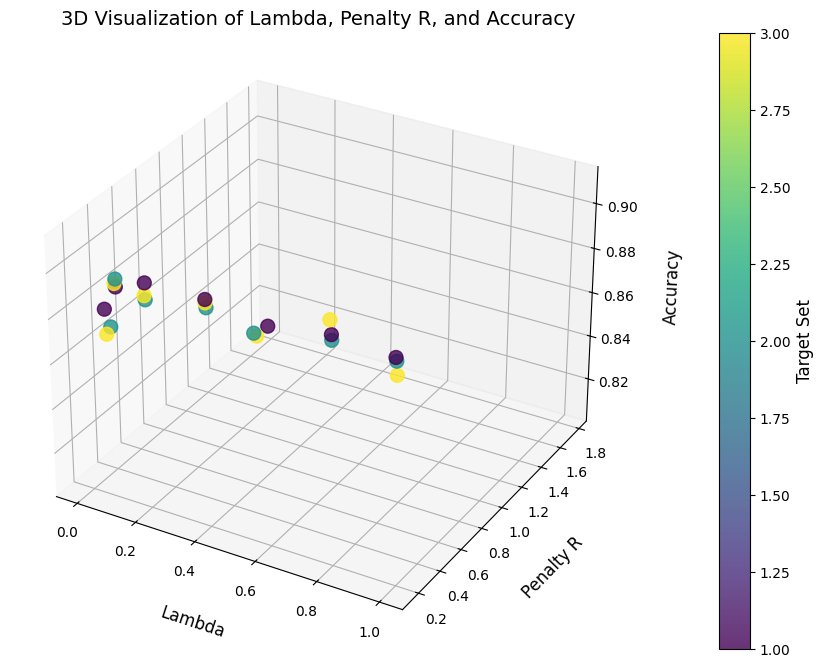

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D


results_df = pd.DataFrame(results_3d)

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')


scatter = ax.scatter(
    results_df['lambda'],
    results_df['penalty_R'],
    results_df['accuracy'],
    c=results_df['target_set'],
    cmap='viridis',
    s=100,
    alpha=0.8
)

cbar = plt.colorbar(scatter, pad=0.1)
cbar.set_label('Target Set', fontsize=12)


ax.set_xlabel('Lambda', labelpad=15, fontsize=12)
ax.set_ylabel('Penalty R', labelpad=15, fontsize=12)
ax.set_zlabel('Accuracy', labelpad=15, fontsize=12)
ax.set_title('3D Visualization of Lambda, Penalty R, and Accuracy', fontsize=14)


ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.tick_params(axis='z', labelsize=10)


ax.grid(True)

# Show the plot
plt.show()





In [ ]:

num_classes = 10
bottleneck_dim = 64
np.random.seed(42)


targets = np.random.randn(num_classes, bottleneck_dim)
targets = targets / np.linalg.norm(targets, axis=1, keepdims=True)
targets_tensor = tf.convert_to_tensor(targets, dtype=tf.float32)


Training with batch size: 64
Epoch 1/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.6449 - val_loss: 0.4379
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3019 - val_loss: 0.3906
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2581 - val_loss: 0.3674
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2337 - val_loss: 0.3586
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2179 - val_loss: 0.3513
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2056 - val_loss: 0.3405
Epoch 7/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1964 - val_loss: 0.3367
Epoch 8/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1870 - val_loss: 0.3329
Epoch 9/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1815 - val_loss: 0.3313
Epoch 10/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1747 - val_loss: 0.3229
Epoch 11/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1697 - val_loss: 0.3228
Epoch 12/50
938/938 ━━

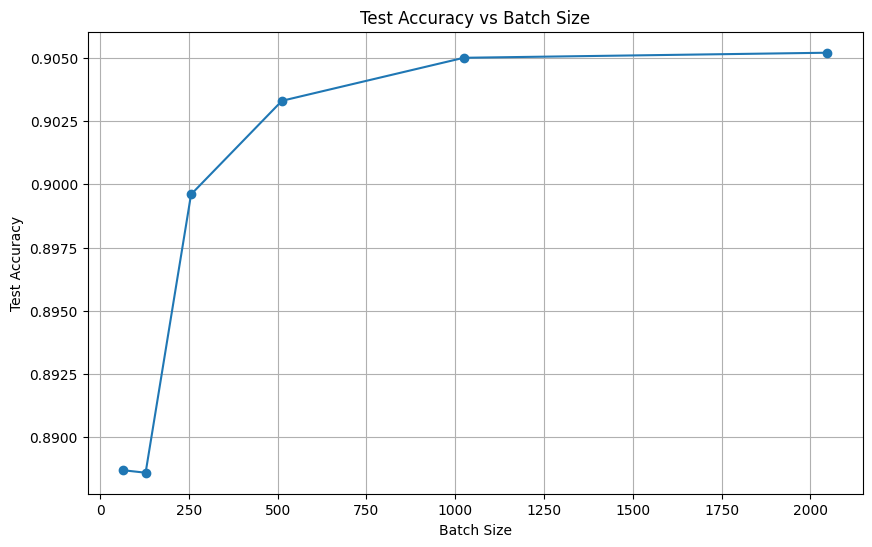

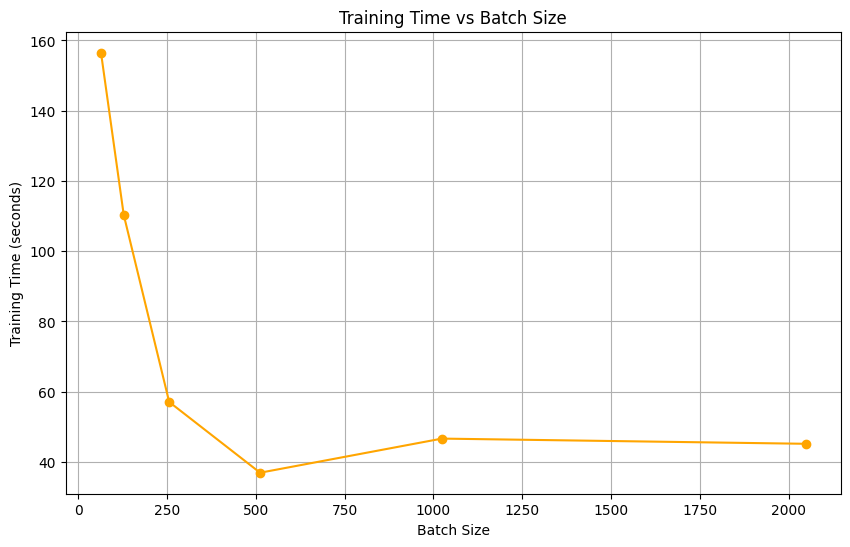

In [ ]:
from inspect import EndOfBlock
def build_sae_with_penalty_final(bottleneck_dim, targets_tensor, lambda_penalty, input_dim=784, num_classes=10):

    # Encoder
    input_layer = Input(shape=(input_dim,), name="input_layer")
    encoder = Dense(800, activation='relu', name="encoder_1")(input_layer)
    encoder = Dense(200, activation='relu', name="encoder_2")(encoder)
    bottleneck = Dense(bottleneck_dim, activation='linear', name="bottleneck")(encoder)

    # Penalty Layer
    labels_input = Input(shape=(num_classes,), name="labels_input")  # One-hot labels
    penalty_layer = PenaltyLayer(
            targets=targets_tensor,
            lambda_penalty=lambda_penalty,
            distance_metric='minkowski',
            p=3
        )(bottleneck, labels_input)


    # Decoder
    decoder = Dense(200, activation='relu', name="decoder_1")(penalty_layer)
    decoder = Dense(800, activation='relu', name="decoder_2")(decoder)
    output_layer = Dense(input_dim, activation='sigmoid', name="output_layer")(decoder)

    autoencoder = Model(inputs=[input_layer, labels_input], outputs=output_layer, name="SAE_with_Penalty")
    return autoencoder


def extract_features_with_penalty(autoencoder, x_data, y_data):

    bottleneck_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('bottleneck').output)
    bottleneck_features = bottleneck_model.predict([x_data, y_data])
    return bottleneck_features



batch_sizes = [64, 128, 256, 512,1024,2048]

# Store results
batch_size_results = []

for batch_size in batch_sizes:
    print(f"\nTraining with batch size: {batch_size}")

    autoencoder_with_penalty = build_sae_with_penalty_final(
        bottleneck_dim=64,
        lambda_penalty=0.8,
        targets_tensor=targets_tensor
    )
    autoencoder_with_penalty.compile(
        optimizer='adam',
        loss=create_custom_loss(autoencoder_with_penalty)
    )


    start_time = time.time()
    history = autoencoder_with_penalty.fit(
        [x_train, y_train], x_train,
        epochs=50,
        batch_size=batch_size,
        validation_data=([x_val, y_val], x_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
        verbose=1
    )
    train_features_penalty = extract_features_with_penalty(autoencoder_with_penalty, x_train, y_train)
    scaler = StandardScaler()
    train_features_scaled_penalty = scaler.fit_transform(train_features_penalty)
     # Train SVM classifier
    svm_classifier_penalty = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
    svm_classifier_penalty.fit(train_features_scaled_penalty, np.argmax(y_train, axis=1))
    end_time = time.time()
    elapsed_time = end_time - start_time



    test_features_penalty = extract_features_with_penalty(autoencoder_with_penalty, x_test, y_test)



    test_features_scaled_penalty = scaler.transform(test_features_penalty)



    test_predictions_penalty = svm_classifier_penalty.predict(test_features_scaled_penalty)
    test_accuracy_penalty = accuracy_score(np.argmax(y_test, axis=1), test_predictions_penalty)


    batch_size_results.append({
        "batch_size": batch_size,
        "test_accuracy": test_accuracy_penalty,
        "elapsed_time": elapsed_time
    })
    print(f"Batch size: {batch_size}, Test Accuracy: {test_accuracy_penalty:.4f}, Training Time: {elapsed_time:.2f} seconds")


import pandas as pd
results_df = pd.DataFrame(batch_size_results)
print("\nBatch Size Results:")
print(results_df)


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(results_df['batch_size'], results_df['test_accuracy'], marker='o')
plt.title('Test Accuracy vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(results_df['batch_size'], results_df['elapsed_time'], marker='o', color='orange')
plt.title('Training Time vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Training Time (seconds)')
plt.grid(True)
plt.show()



Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 1.0506 - val_loss: 0.6423
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.4528 - val_loss: 0.4863
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3374 - val_loss: 0.4314
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2934 - val_loss: 0.4022
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2685 - val_loss: 0.3841
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2514 - val_loss: 0.3787
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2400 - val_loss: 0.3673
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2256 - val_loss: 0.3640
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2175 - val_loss: 0.3573
Epoch 10/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2106 - val_loss: 0.3528
Epoch 11/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2049 - val_loss: 0.3482
Epoch 12/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/ste

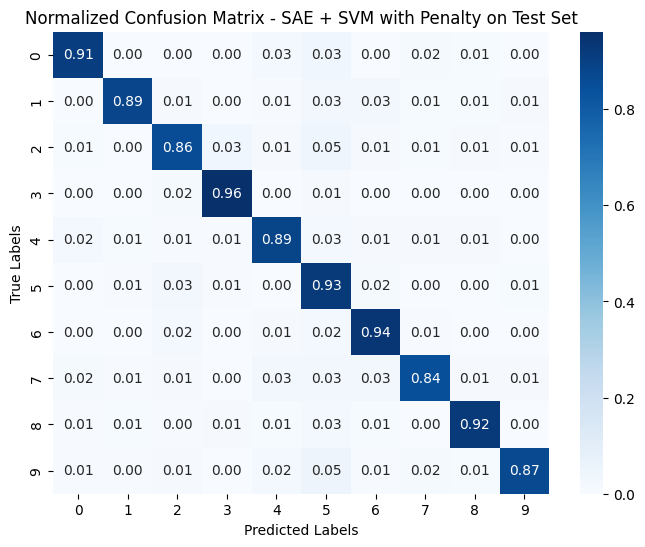

In [ ]:
# Define SAE architecture with Penalty Layer
autoencoder_with_penalty = build_sae_with_penalty_final(
    bottleneck_dim=64,
    lambda_penalty=0.8,
    targets_tensor=targets_tensor
)

# Compile the autoencoder with a custom loss function
autoencoder_with_penalty.compile(
    optimizer='adam',
    loss=create_custom_loss(autoencoder_with_penalty)
)


batch_size = 512

start_time = time.time()
history = autoencoder_with_penalty.fit(
    [x_train, y_train], x_train,
    epochs=50,
    batch_size=batch_size,
    validation_data=([x_val, y_val], x_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)
y_train_labels = np.argmax(y_train, axis=1)
train_features_penalty = extract_features_with_penalty(autoencoder_with_penalty, x_train, y_train)
scaler = StandardScaler()
train_features_scaled_penalty = scaler.fit_transform(train_features_penalty)
svm_classifier_penalty = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_classifier_penalty.fit(train_features_scaled_penalty, y_train_labels)

end_time = time.time()
elapsed_time = end_time - start_time




test_features_penalty = extract_features_with_penalty(autoencoder_with_penalty, x_test, y_test)


test_features_scaled_penalty = scaler.transform(test_features_penalty)



y_test_labels = np.argmax(y_test, axis=1)





test_predictions_penalty = svm_classifier_penalty.predict(test_features_scaled_penalty)
test_accuracy_penalty = accuracy_score(y_test_labels, test_predictions_penalty)

print(f"\nSAE + SVM Test Accuracy with Penalty: {test_accuracy_penalty:.4f}")
print(f"Train SAE+SVM with Penalty time: {elapsed_time:.2f} seconds")


cm_penalty = confusion_matrix(y_test_labels, test_predictions_penalty, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm_penalty, annot=True, cmap='Blues', fmt='.2f')
plt.title("Normalized Confusion Matrix - SAE + SVM with Penalty on Test Set")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()